In [1]:
import igraph
import matplotlib.pyplot as plt
import numpy as np
from os import path
import pandas as pd
import seaborn as sns
from selfregulation.utils.utils import get_behav_data
from sklearn.decomposition import FactorAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from selfregulation.utils.r_to_py_utils import GPArotation, missForest, psychFA
from fancyimpute import SoftImpute
%matplotlib inline

Note: no visible global function definition for 'radixsort' 



Using TensorFlow backend.


### Load Data

Load both cleaned and imputed data. Set up a helper function to quickly impute data within the Kfold split. Can't use data where imputation was performed over the whole dataset as there will be data leakage between training and test.

In [2]:
datafile = 'Complete_05-13-2017'
# load data
# imputed data
imputed_data = get_behav_data(dataset=datafile, file = 'meaningful_variables_imputed.csv')
imputed_task_data = get_behav_data(dataset=datafile, file = 'taskdata_imputed.csv')
imputed_survey_data = imputed_data.drop(imputed_task_data.columns, axis = 1)
imputed_datasets = {'survey': imputed_survey_data, 'task': imputed_task_data, 'complete': imputed_data}

results = {'survey': {}, 'task': {}, 'complete': {}}

Getting datasets...:
 /home/ian/Experiments/expfactory/Self_Regulation_Ontology/Data/Complete_05-13-2017
Getting datasets...:
 /home/ian/Experiments/expfactory/Self_Regulation_Ontology/Data/Complete_05-13-2017
Getting datasets...:
 /home/ian/Experiments/expfactory/Self_Regulation_Ontology/Data/Complete_05-13-2017
Getting datasets...:
 /home/ian/Experiments/expfactory/Self_Regulation_Ontology/Data/Complete_05-13-2017


Reorder data in some slightly interpretable way

In [185]:
for key, dataset in imputed_datasets.items():
    sorted_columns = []
    survey_cols = ('survey', dataset.filter(regex='survey').columns.tolist())
    drift_cols = ('drift', dataset.filter(regex='\.hddm_drift').columns.tolist())
    drift_contrast_cols = ('drift con', dataset.filter(regex='\..*_hddm_drift').columns.tolist())
    thresh_cols = ('thresh', dataset.filter(regex='\.hddm_thresh').columns.tolist())
    thresh_contrast_cols = ('thresh con', dataset.filter(regex='\..*_hddm_thresh').columns.tolist())
    non_decision_cols = ('non-decision', dataset.filter(regex='\.hddm_non_decision').columns.tolist())
    non_decision_contrast_cols = ('non-decision con', dataset.filter(regex='\..*_hddm_non_decision').columns.tolist())
    stop_cols = ('stop', dataset.filter(regex='stop').columns.tolist())
    discount_cols = ('discount', dataset.filter(regex='discount').columns.tolist())
    leftover_cols = ('misc', dataset.columns)

    tmp_groups = [survey_cols,
                  drift_cols, drift_contrast_cols, 
                  thresh_cols, thresh_contrast_cols,
                  non_decision_cols, non_decision_contrast_cols,
                  stop_cols, discount_cols,
                  leftover_cols]
    putative_groups = []
    results[key]['putative_groups'] = putative_groups
    for name, group in tmp_groups:
        group = sorted(list(set(group)-set(sorted_columns)))
        sorted_columns+=group
        putative_groups.append((name,group))
    imputed_datasets[key] = dataset.reindex_axis(sorted_columns, axis=1)

# Calculate best number of components

### Define Helper functions

In [67]:
# using for speed, for the time being
def SoftImpute_df(data):
    imputed_mat = SoftImpute(verbose=False).complete(data)
    return pd.DataFrame(data=imputed_mat, columns=data.columns, index=data.index)

def run_FA(n_components,data,cv):
    fa=FactorAnalysis(n_components)
    scores = []
    # cross-validate fit across different train/test splits
    for train_index, test_index in cv.split(data.values):
        data_train, data_test = data.iloc[train_index], \
                                data.iloc[test_index]
        # Impute (replace with missForest later)
        imputed_train = SoftImpute_df(data_train)
        imputed_test = SoftImpute_df(data_test)
        # Scale data
        scaler = StandardScaler()
        scaled_train = scaler.fit_transform(imputed_train)
        scaled_test = scaler.transform(imputed_test)
        # fit model on training
        fa.fit(scaled_train)
        # score on test set
        scores.append(fa.score(scaled_test))
    #average score across kfolds
    score = np.mean(scores)
    return score, fa

def find_optimal_components(data, method='sklearn', cv=None):
    if method == 'sklearn':
        assert cv, "Must Supply a CV if using sklearn"
        # find best number of components
        n_components = range(1,20)
        best_c = 0
        component_scores = []
        for c in n_components:
            score, fa = run_FA(c,data,cv)
            component_scores.append(score)
        best_c = np.argmax(component_scores)+1
        print('Best Component: ', best_c)
        return best_c, component_scores
    elif method == 'psych':
        BICs = []
        outputs = []
        n_components = range(1,20)
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(data)
        for c in n_components:
            fa, output = psychFA(scaled_data, c, method='ml')
            BICs.append(output['BIC'])
            outputs.append(output)
        best_c = np.argmin(BICs)+1
        print('Best Component: ', best_c)
        return best_c, BICs

### Calculate best number of components using BIC (R Psych package)

Dataset: survey


/home/ian/anaconda2/envs/py34/lib/python3.4/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Loading required namespace: GPArotation

  warnings.warn(x, RRuntimeWarning)


Best Component:  12
Dataset: complete
Best Component:  10
Dataset: task
Best Component:  8


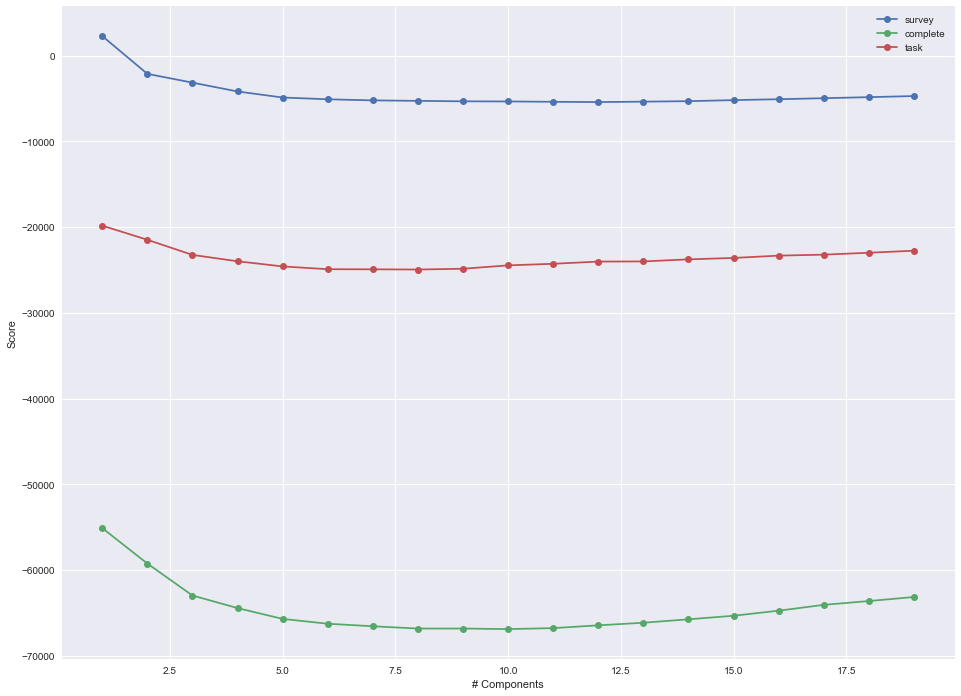

In [4]:
for label,data in imputed_datasets.items():
    print('Dataset: %s' % label)
    best_c, BICs = find_optimal_components(data, method='psych')
    results[label]['psych_best_c'] = best_c
    results[label]['psych_BICs'] = BICs

fig = plt.figure(figsize=(16,12))
for bic in [d['psych_BICs'] for d in results.values()]:
    plt.plot(range(1,len(bic)+1),bic, '-o')
plt.legend(results.keys(), loc = 'best')
plt.xlabel('# Components')
plt.ylabel('Score')

# Interpret Factor Analysis Solutions
Above we found that the best number of components were as follows:

**Psych**:

Task: {{results['task']['psych_best_c']}}

Survey: {{results['survey']['psych_best_c']}}

Complete: {{results['complete']['psych_best_c']}}

First we will look at the best number of components, then we will look at the solution at each dimensionality and plot the relationships between dimensions

### Complete Dataset (Surveys and tasks)


In [186]:
# perform factor analysis
complete_results = results['complete']
best_c = complete_results['psych_best_c']
data = imputed_datasets['complete']
putative_groups = results['complete']['putative_groups']
fa, output = psychFA(data, best_c)

In [411]:
abs_survey_loadings = loading_df.filter(regex='survey', axis=0).iloc[:,:best_c].abs().mean()
abs_task_loadings = loading_df.drop(loading_df.filter(regex='survey', axis=0).index, axis=0).iloc[:,:best_c].abs().mean()
pd.concat([abs_survey_loadings, -abs_task_loadings],axis=1).sort_values(by=[0,1])

,0,1
4,0.033750,-0.124097
9,0.036042,-0.078083
6,0.041555,-0.136892
7,0.044821,-0.082621
0,0.065117,-0.216713
5,0.116373,-0.112136
8,0.162963,-0.053516
2,0.195757,-0.048845
3,0.222276,-0.041912
1,0.254624,-0.047296


In [414]:
### Print top variables for each factor
def print_top_factors(fa_output, n = 4):
    # number of variables to display
    loading_df = pd.DataFrame(fa_output['loadings'], index=data.columns)
    for i,column in loading_df.iteritems():
        sort_index = np.argsort(abs(column))[::-1] # descending order
        top_vars = column[sort_index][0:n]
        print('\nFACTOR %s' % i)
        print(top_vars)
    return loading_df
        
loading_df = print_top_factors(output, 10)
# sort by maximum loading on surveys
sorting_index = np.argsort(loading_df.filter(regex='survey',axis=0).abs().mean()).tolist()[::-1]
loading_df = loading_df.loc[:,sorting_index]
loading_df.columns = range(best_c)

loading_df.loc[:,'task'] = [i.split('.')[0] for i in loading_df.index]


FACTOR 0
choice_reaction_time.hddm_drift          0.765579
dot_pattern_expectancy.hddm_drift        0.753353
shape_matching.hddm_drift                0.692506
directed_forgetting.hddm_drift           0.685221
threebytwo.hddm_drift                    0.675468
dot_pattern_expectancy.dprime            0.675010
simon.hddm_drift                         0.652082
recent_probes.hddm_drift                 0.637691
stop_signal.hddm_drift                   0.591302
stim_selective_stop_signal.hddm_drift    0.578472
Name: 0, dtype: float64

FACTOR 1
time_perspective_survey.future                                      0.868852
upps_impulsivity_survey.lack_of_perseverance                       -0.770718
bis11_survey.Nonplanning                                           -0.767206
upps_impulsivity_survey.lack_of_premeditation                      -0.680496
self_regulation_survey.control                                      0.667986
selection_optimization_compensation_survey.optimization.ReflogTr   -0.6

### Do the components seem to capture surveys and tasks differently?

In [418]:
abs_average_loadings

,survey,task
0,0.254624,0.047296
1,0.222276,0.041912
2,0.195757,0.048845
3,0.162963,0.053516
4,0.116373,0.112136
5,0.065117,0.216713
6,0.044821,0.082621
7,0.041555,0.136892
8,0.036042,0.078083
9,0.033750,0.124097


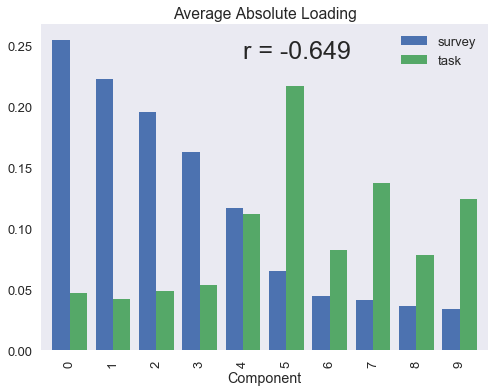

In [427]:
# get absolute average loadings for surveys and tasks per component
abs_survey_loadings = loading_df.filter(regex='survey', axis=0).iloc[:,:best_c].abs().mean()
abs_task_loadings = loading_df.drop(loading_df.filter(regex='survey', axis=0).index, axis=0).iloc[:,:best_c].abs().mean()
abs_average_loadings = pd.concat([abs_survey_loadings, abs_task_loadings],axis=1)
abs_average_loadings.columns = ['survey','task']

# plot
sns.set_style("dark")
fig, ax = plt.subplots(figsize=(8,6))
abs_average_loadings.plot(kind='bar',legend=True, width=.8,  ax = ax)
plt.xlabel('Component')
ax.set_title('Average Absolute Loading')
# add correlation of two components to plot
corr = abs_average_loadings.corr().iloc[0,1]
ax.text(4,.24, 'r = %.3f' % corr, fontsize=25)


### Visualize loadings of components on each variable

In [480]:
import numpy as np
import matplotlib.cm as cm
from matplotlib.pyplot import figure, show, rc


# force square figure and square axes looks better for polar, IMO


def plot_loadings(ax,component_loadings, groups):
    colors = sns.hls_palette(len(groups), l=.5, s=.8)
    ax.set_xticklabels([''])
    ax.set_yticklabels([''])
    
    N = len(component_loadings)
    theta = np.arange(0.0, 2*np.pi, 2*np.pi/N)
    radii = abs(component_loadings)
    width = np.pi/(N/2)*np.ones(N)
    bars = ax.bar(theta, radii, width=width, bottom=0.0)
    for i,r,bar in zip(range(N),radii, bars):
        color_index = sum((np.cumsum([len(g[1]) for g in putative_groups])<i))
        bar.set_facecolor(colors[color_index])
        bar.set_alpha(1)
    plt.legend()
    return colors
        
def create_categorical_legend(labels,colors, ax):
    import matplotlib
    descriptions = [g[0] for g in putative_groups]
    def create_proxy(color):
        line = matplotlib.lines.Line2D([0], [0], linestyle='none',
                    mec='none', marker='o', color=color)
        return line
    proxies = [create_proxy(item) for item in colors]
    ax.legend(proxies, labels, numpoints=1, markerscale=2.5, bbox_to_anchor=(1, .5), prop={'size':15})

/home/ian/anaconda2/envs/py34/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


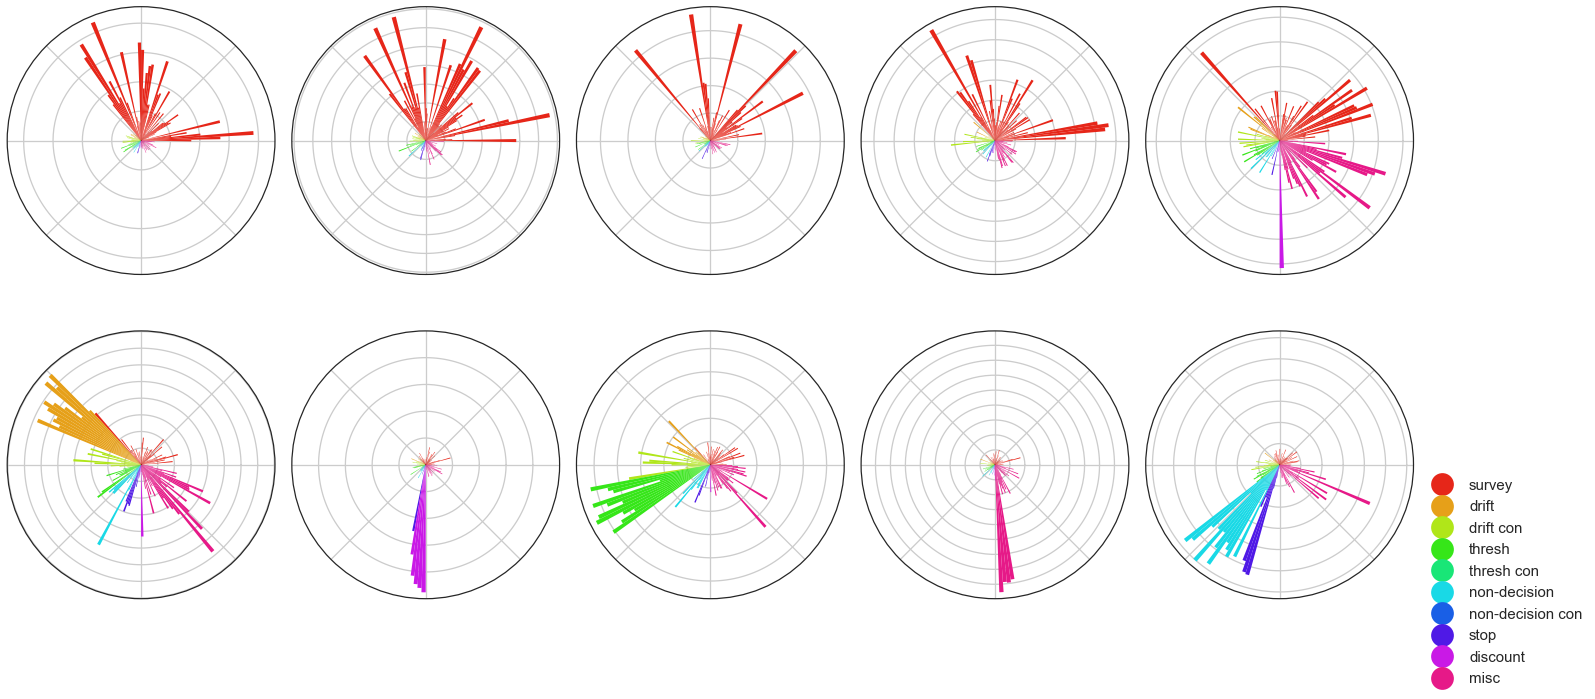

In [481]:
sns.set_style("white")
fig = plt.figure(figsize=(20,10))
for i in range(best_c):
    component_loadings = loading_df.iloc[:,i]
    ax=plt.subplot(2,np.ceil(best_c/2),i+1,polar=True)
    colors = plot_loadings(ax,component_loadings,putative_groups)
fig.tight_layout()
create_categorical_legend([g[0] for g in putative_groups],colors,ax)

## Name the Dimensions

In [485]:
factor_names = {}

In [488]:
fa, output = psychFA(data, 1)
loading_df = print_top_factors(output,10)
factor_names[1] = ['Self Regulation']


FACTOR 0
brief_self_control_survey.self_control              0.842100
self_regulation_survey.control                      0.836300
upps_impulsivity_survey.negative_urgency           -0.772172
upps_impulsivity_survey.lack_of_perseverance       -0.769280
grit_scale_survey.grit                              0.764086
bis11_survey.Nonplanning                           -0.735643
five_facet_mindfulness_survey.act_with_awareness    0.715786
time_perspective_survey.future                      0.692176
mindful_attention_awareness_survey.mindfulness      0.676660
upps_impulsivity_survey.positive_urgency           -0.670092
Name: 0, dtype: float64


**One Factor**

Factor 0: {{factor_names[1][0]}}


In [489]:
fa, output = psychFA(data, 2)
loading_df = print_top_factors(output, 6)
factor_names[2] = ['Self Regulation','Drift']


FACTOR 0
self_regulation_survey.control                     -0.862199
brief_self_control_survey.self_control             -0.853370
grit_scale_survey.grit                             -0.806879
upps_impulsivity_survey.lack_of_perseverance        0.804995
upps_impulsivity_survey.negative_urgency            0.756447
five_facet_mindfulness_survey.act_with_awareness   -0.741146
Name: 0, dtype: float64

FACTOR 1
dot_pattern_expectancy.hddm_drift    0.676950
directed_forgetting.hddm_drift       0.622885
dot_pattern_expectancy.dprime        0.607549
threebytwo.hddm_drift                0.600074
choice_reaction_time.hddm_drift      0.588037
ravens.score                         0.578385
Name: 1, dtype: float64


**Two Factors**

Factor 0: {{factor_names[2][0]}}

Factor 1: {{factor_names[2][1]}}

In [491]:
fa, output = psychFA(data, 3)
loading_df = print_top_factors(output, 6)
factor_names[3] = ['Self Regulation','Drift','Sensation Seeking']


FACTOR 0
self_regulation_survey.control                      0.905681
brief_self_control_survey.self_control              0.857412
grit_scale_survey.grit                              0.856110
upps_impulsivity_survey.lack_of_perseverance       -0.852298
five_facet_mindfulness_survey.act_with_awareness    0.767617
upps_impulsivity_survey.negative_urgency           -0.754758
Name: 0, dtype: float64

FACTOR 1
threebytwo.hddm_drift                0.709318
dot_pattern_expectancy.hddm_drift    0.702252
directed_forgetting.hddm_drift       0.656627
ravens.score                         0.650516
adaptive_n_back.mean_load            0.626271
dot_pattern_expectancy.dprime        0.614183
Name: 1, dtype: float64

FACTOR 2
upps_impulsivity_survey.sensation_seeking            0.916173
impulsive_venture_survey.venturesomeness             0.895913
sensation_seeking_survey.thrill_adventure_seeking    0.849203
dospert_rt_survey.recreational                       0.804387
bis_bas_survey.BAS_fun_seeking  

**Three Factors**

Factor 0: {{factor_names[3][0]}}

Factor 1: {{factor_names[3][1]}}

Factor 2: {{factor_names[3][2]}}

In [ ]:
fa, output = psychFA(data, 4)
loading_df = print_top_factors(output, 4)
factor_names[4] = ['Drift','Encoding Time','Discount','Mem/Unclear']

**Four Factors**

Factor 0: {{factor_names[4][0]}}

Factor 1: {{factor_names[4][1]}}

Factor 2: {{factor_names[4][2]}}

Factor 3: {{factor_names[4][3]}}

In [ ]:
fa, output = psychFA(data, 5)
loading_df = print_top_factors(output, 6)
factor_names[5] = ['Drift','Encoding Time','Mem/Unclear','Discount','Thresh']

**Five Factors**

Factor 0: {{factor_names[5][0]}}

Factor 1: {{factor_names[5][1]}}

Factor 2: {{factor_names[5][2]}}

Factor 3: {{factor_names[5][3]}}

Factor 4: {{factor_names[5][4]}}

In [ ]:
fa, output = psychFA(data, 6)
loading_df = print_top_factors(output)
factor_names[6] = ['Drift','Encoding Time','Discount','Thresh','Mem','Risk']

**Six Factors**

Factor 0: {{factor_names[6][0]}}

Factor 1: {{factor_names[6][1]}}

Factor 2: {{factor_names[6][2]}}

Factor 3: {{factor_names[6][3]}}

Factor 4: {{factor_names[6][4]}}

Factor 5: {{factor_names[6][5]}}

## Plot relationships between solutions at different dimensionalities

Each factor analytic solution gives us some components. By correlating the components at one level with the next, we can get a sense for how similar these components are. When we move to 3 dimensions from 2, is it the case that one of the dimensions just split? Or is there a new, non-hierarchical parcellation of the space?



In [482]:
# helper functions for plotting dimensionality relations
# compute FA with different dimensionalities and quantify similarity
def dimensional_similarity(factors, reference):
    ''' This function returns an N x M correlation matrix where N is the number
    of reference (lower dimension) factors and M is the number of higher dimension
    factors
    '''
    relation = np.corrcoef(reference.T, factors.T)
    # each row is a reference factor, each column a new factor
    relation=relation[:reference.shape[1], reference.shape[1]:]
    return relation

def construct_relational_tree(similarities, labels=None, filey=None):
    ''' Takes a list of similarities and constructs a tree graph, then plots
    '''
    G = igraph.Graph()
    layer_start = 0
    colors = ['red','blue','green','violet']*4
    for similarity in similarities:
        curr_color = colors.pop()
        origin_length = similarity.shape[0]
        target_length = similarity.shape[1]
        if len(G.vs)==0:
            G.add_vertices(origin_length)
        G.add_vertices(target_length)
        for i in range(origin_length):
            for j in range(target_length):
                G.add_edge(i+layer_start,j+origin_length+layer_start,
                           weight=abs(similarity[i,j]*5),color = curr_color)
        layer_start+=similarity.shape[0]
    layout = G.layout_reingold_tilford(root = [0])
    if labels == None:
        labels = G.vs.indices
    plot = igraph.plot(G, layout=layout, **{'inline': True, 'vertex_label': labels, 
                                            'vertex_color': 'white',
                                            'vertex_size': 50, 
                                         'edge_width':[w for w in G.es['weight']], 
                                         'edge_color': G.es['color'], 
                                            'bbox': (1000,1000), 'margin':100})
    if filey:
        plot.save(filey)
    #G.write_dot('test.dot')
    return G


In [483]:
# construct array of component similarities
similarities = []
components = np.sort(list(factor_names.keys()))
reference = None
for c in components:
    fa, output = psychFA(data,c)
    result = pd.DataFrame(output['scores'], data.index)
    if reference is not None:
        similarity = dimensional_similarity(result,reference)
        similarities.append(similarity)
    reference = result




NameError: name 'factor_names' is not defined

In [ ]:
# plot component similarity tree
labels = []
for c in components:
    labels+=factor_names[c]
similarity_tree = construct_relational_tree(similarities, 
                                            labels=labels, filey=path.join('Plots', 'task_graph.png'))